In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
torch.set_default_tensor_type(torch.cuda.FloatTensor)
import gpytorch
from Clean import Clean
import numpy as np
import time

%matplotlib inline

# Data Prep

In [2]:
n = 1000

df = pd.read_csv('./data/FM_2000-2019.csv')
print(df.shape)
df_all = df[df['gp_all_0_a'] >= 30]
# df = df_all[0:n]
df = df_all[0:-n]
df_star = df_all[-n:]
print(df.shape)
print(df_star.shape)

(24171, 459)
(13492, 459)
(1000, 459)


In [3]:
games = 30
q = 1

clean = Clean(df,games)
features = clean.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y = clean.get_target(q).values
cols = features.columns
x = features.values
print(x.shape, y.shape)

clean_test = Clean(df_star,games)
features_test = clean_test.get_features(['e-def-rating','e-off-rating','e-pace'],q)
y_star = clean_test.get_target(q).values
cols_test = features_test.columns
x_star = features_test.values
print(x_star.shape, y_star.shape)

(13301, 24) (13301,)
(994, 24) (994,)


# Fit a GP (GPyTorch)

In [4]:
class SpectralMixtureGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SpectralMixtureGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module.initialize(constant=50.)
        self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=train_x.shape[1])
        self.covar_module.initialize_from_data(train_x, train_y)

    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
class GPModelSKI(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelSKI, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.mean_module.initialize(constant=50.)
        self.covar_module = gpytorch.kernels.AdditiveStructureKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
                , grid_size=1000, num_dims=1)
            , num_dims=train_x.shape[1])

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
train_x = torch.from_numpy(x).double()
train_y = torch.from_numpy(y).double()
test_x = torch.from_numpy(x_star).double()
test_y = torch.from_numpy(y_star).double()

In [7]:
train_x = train_x.cuda()
train_y = train_y.cuda()
test_x = test_x.cuda()
test_y = test_y.cuda()


In [12]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
# model = SpectralMixtureGPModel(train_x, train_y, likelihood)
model = GPModelSKI(train_x, train_y, likelihood)

In [13]:
model = model.cuda()
likelihood = likelihood.cuda()

In [14]:
# Find optimal model hyperparameters
model.double()
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train(training_iter):
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()), end='\r')
        optimizer.step()
    print('Iter %d/%d - Loss: %.3f' % (training_iter, training_iter, loss.item()))

# with gpytorch.settings.use_toeplitz(False)\
#         , gpytorch.beta_features.checkpoint_kernel(10000)\
#         , gpytorch.settings.max_preconditioner_size(0):
with gpytorch.settings.use_toeplitz(False):
    %time train(500)

Iter 500/500 - Loss: 4.776
Wall time: 12min 9s


In [15]:
torch.save(model.state_dict(), 'ski_full_model_cuda_500.pth')

In [24]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    ppc = likelihood(model(test_x))
    # ppc = likelihood(model(train_x))
    # print(ppc.mean.cpu().numpy())
    samples = ppc.sample(sample_shape=torch.Size([100000,])).cpu().numpy()
    print(samples.shape)

(100000, 994)


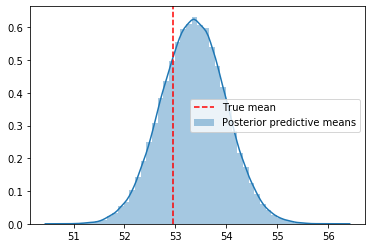

In [25]:
fig, ax = plt.subplots()
sns.distplot(samples.mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(test_y.mean(), ls='--', color='r', label='True mean')
# ax.axvline(train_y.mean(), ls='--', color='r', label='True mean')
ax.legend(); 


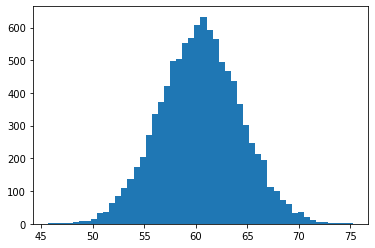

In [48]:
samples_0 = samples[:,0]

fig, ax = plt.subplots()
ax.hist(samples_0, bins=50);

In [26]:
print(y[0])
print(samples_0.shape)
print(samples_0.mean())


59
(10000,)
58.63169306683


In [27]:
a = np.array([100,200])
print(a.shape)
print(a[-1])
def train(training_iter):
    loss_list = np.array([100])
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f - Diff: %.3f - AvgLoss: %.3f' 
              % (i + 1, training_iter, loss.item(), loss_list[-1]-loss.item(), loss_list[-20:].mean()), end='\r')
        if abs(loss.item()-loss_list[-20:].mean())<1e-4:
            print('Converged: Iter %d/%d - Loss: %.3f - Diff: %.3f - AvgLoss: %.3f' 
              % (i + 1, training_iter, loss.item(), loss_list[-1]-loss.item(), loss_list[-20:].mean()))
            return
        loss_list = np.append(loss_list, [loss.item()])
        optimizer.step()

(2,)
200
150.0
